# Goal

Play around with all laws voted over the last 20 years (since 1997 until 2018) to analyse the voting behavior of two parties. 

The goal here is not analyse the historical adjacency matrix of laws, for it, please check `analysis-historical-adjacency.ipynb`

## Main Takeaways

- High level of divergency does not mean that laws won't be approved (look congress 111 where the level of approvals kept the same but the divergency was highest possible)
- Republicans have dominated democrats until 109 congress (2005-2007), then democrats took the power until congress 113 (2013-2015) and then republicans dominate until now
- According with our sample of 2 data points, Obama - Democrat assumes in 2009 (2 years before democrats have dominated the congress) and Trump - Republican assumes in 2018 (2 years before republicans have already taken the power again). Is it the congress a good predictor of the next presindent?
- The highest divergence was in the congress 111 which started when Obama assumed as president. The rate of republicans' "yes" for laws has dropped during this congress.
- When a party is dominated, it takes decisions less consistently (a lot of discondance inside the party) - It happened with Republicans in 110 congress and in 115 congress with Democrats
- When a party starts to dominated, it takes decisions more consistently (there is not a lot of discondance and everyone votes the same) - It happened with Democrats in 110 congress and in 115 with Republicans
- In the last semester of the first year, the level of laws proposed is much lower than in the other semesters. In trends can not be observed in the last semester of the second year.

> Domination means that most of laws were approved because JUST ONE of the parties wanted it

## Further Analysis

It would be interesting analyse the approval rate by subject as well



In [1]:
import os
import pandas as pd
import numpy as np

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True, rc=None)

In [3]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
print(all_laws.shape)

(6834, 17)


In [4]:
LOOKUP_RESULT = {
    'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
    'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
    'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
    'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
    'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
    'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected'
}

In [5]:
all_laws['result_ok'] = all_laws.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefinied'))
all_laws['quarter'] = all_laws['year'].apply(str) + '-' + pd.to_datetime(all_laws.date).dt.quarter.apply(str) 

In [6]:
pd.DataFrame(all_laws.result_ok.value_counts())

,result_ok
passed,4293
rejected,2314
undefinied,227


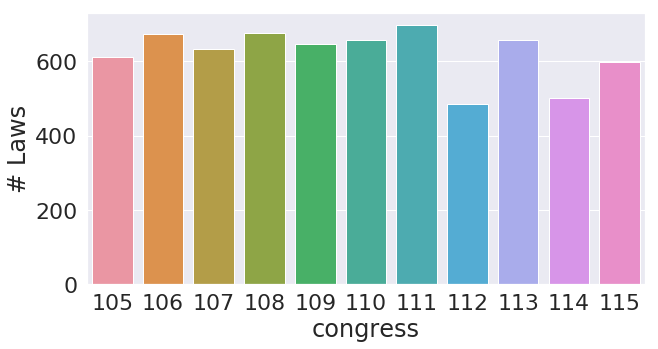

In [8]:
plt.figure(figsize=(10, 5))
d = pd.DataFrame(all_laws.groupby('congress').size()).reset_index().rename(columns={0: 'count'})
sns.barplot(y='count', x='congress', data=d);
plt.ylabel('# Laws');

In [9]:
all_laws.columns

Index(['bill_api_uri', 'congress', 'date', 'democrats_no', 'democrats_yes',
       'independent_no', 'independent_yes', 'month', 'republican_no',
       'republican_yes', 'result', 'total_no', 'total_not_voting', 'total_yes',
       'vote_type', 'vote_uri', 'year', 'result_ok', 'quarter'],
      dtype='object')

In [25]:
# plt.figure(figsize=(10, 5))
# d = pd.DataFrame(all_laws.groupby('quarter_join').size()).reset_index().rename(columns={0: 'count'})
# sns.barplot(y='count', x='quarter_join', data=d);
# plt.ylabel('# Laws');

## Historical Passed over Rejected

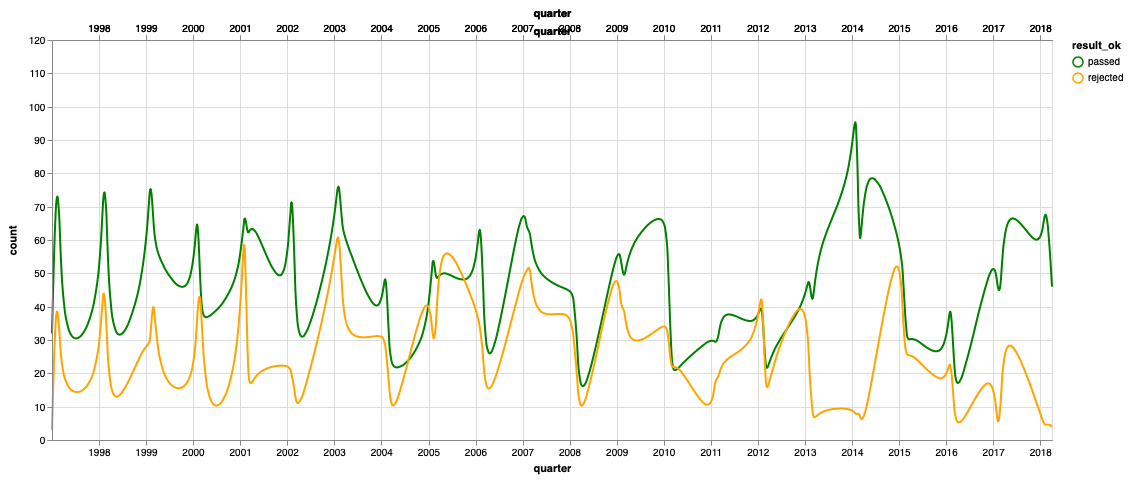

In [11]:
d = pd.DataFrame(all_laws.groupby(['quarter', 'result_ok']).size()).reset_index()
d = d.rename(columns={0: 'count'})
d['quarter'] = pd.to_datetime(d['quarter'])


# Chart
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['quarter'], empty='none')
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='quarter:T',
    y='count:Q',
    color=alt.Color('result_ok:N', 
                    scale=alt.Scale(domain=['passed', 'rejected'], 
                                    range=['green', 'orange'])))
selectors = alt.Chart().mark_point().encode(
    x='quarter:Q',
    opacity=alt.value(0),).add_selection(nearest)
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0)))
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'count:Q', alt.value(' ')))
rules = alt.Chart().mark_rule(color='gray').encode(
    x='quarter:Q',).transform_filter(nearest)

alt.layer(line, selectors, points, rules, text, data=d, width=1000, height=400)

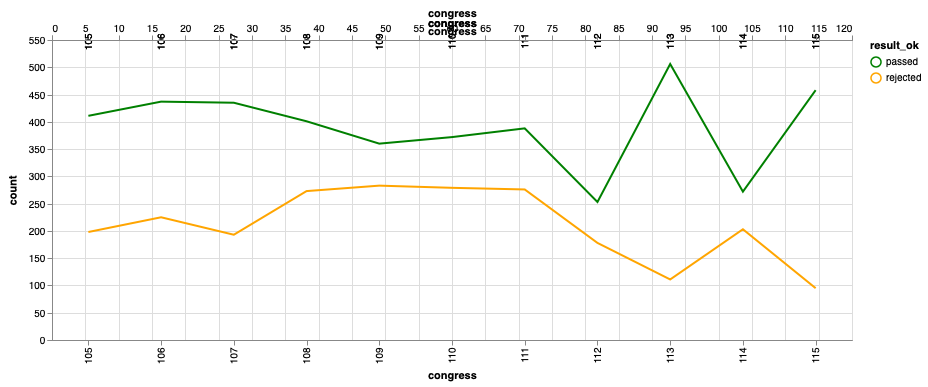

In [12]:
d = pd.DataFrame(all_laws.groupby(['congress', 'result_ok']).size()).reset_index()
d = d.rename(columns={0: 'count'})

# Chart
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['quarter'], empty='none')
line = alt.Chart().mark_line().encode(
    x='congress:O',
    y='count:Q',
    color=alt.Color('result_ok:N', 
                    scale=alt.Scale(domain=['passed', 'rejected'], 
                                    range=['green', 'orange'])))
selectors = alt.Chart().mark_point().encode(
    x='congress:Q',
    opacity=alt.value(0),).add_selection(nearest)
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0)))
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'count:Q', alt.value(' ')))
rules = alt.Chart().mark_rule(color='gray').encode(
    x='congress:Q',).transform_filter(nearest)

alt.layer(line, selectors, points, rules, text, data=d, width=800, height=300)

## Historical Concordance Inter and Intra Party

### Inter Party

In [13]:
# Kendall: coeffient that mesures difference between concordante pairs and discordant pairs
all_laws['majority_republican'] = (all_laws['republican_yes'] > all_laws['republican_no']).apply(int)
all_laws['majority_democrats'] = (all_laws['democrats_yes'] > all_laws['democrats_no']).apply(int)
all_laws[['majority_democrats', 'majority_republican']].corr('kendall')

,majority_democrats,majority_republican
majority_democrats,1.000000,-0.351475
majority_republican,-0.351475,1.000000


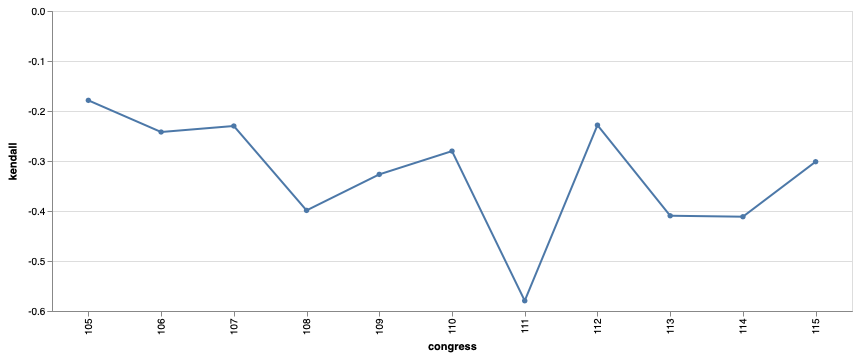

In [14]:
d = pd.DataFrame(all_laws.groupby('congress')[['majority_republican', 'majority_democrats']]
                 .apply(lambda x: x.corr('kendall').iloc[0,1])).reset_index().rename(columns={0: 'kendall'})

alt.Chart(d, width=800, height=300).mark_line(point=True).encode(
    x='congress:O',
    y='kendall:Q')

#### Who make the decisions?

In [15]:
def who_decided(democrats_yes, democrats_no, republican_yes, republican_no, result):
    if result == 'passed':
        if democrats_yes > democrats_no and republican_yes > republican_no:
            return 'both'
        elif democrats_yes < democrats_no and republican_yes > republican_no:
            return 'republican'
        else:
            return 'democrats'
    else:
        if democrats_yes < democrats_no and republican_yes < republican_no:
            return 'both'
        elif democrats_yes > democrats_no and republican_yes < republican_no:
            return 'republican'
        else:
            return 'democrats'

In [16]:
all_laws['final_decision'] = all_laws.apply(lambda x: who_decided(x['democrats_yes'], x['democrats_no'], x['republican_yes'], x['republican_no'], x['result_ok']), axis=1)
pd.DataFrame(all_laws['final_decision'].value_counts())

,final_decision
both,2591
republican,2132
democrats,2111


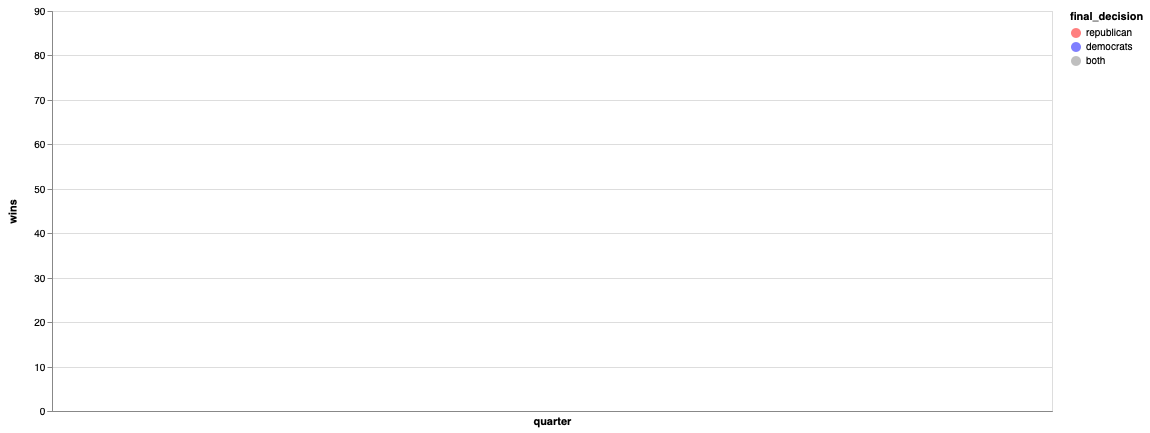

In [19]:
d = pd.DataFrame(all_laws.groupby(['quarter', 'final_decision']).size()).reset_index().rename(columns={0: 'wins'})
counts = pd.DataFrame(all_laws.groupby(['quarter']).size()).reset_index().rename(columns={0: 'total'})
d = d.merge(counts)
d['wins'] = d['wins'] / d['total']

alt.Chart(d, width=1000, height=400).mark_area(opacity=0.5).encode(
    x="quarter:T",
    y="wins:Q",
    color=alt.Color("final_decision:N", 
                    scale=alt.Scale(domain=['republican', 'democrats', 'both'], 
                              range=[pal['republican'], pal['democrats'], 'grey'])))

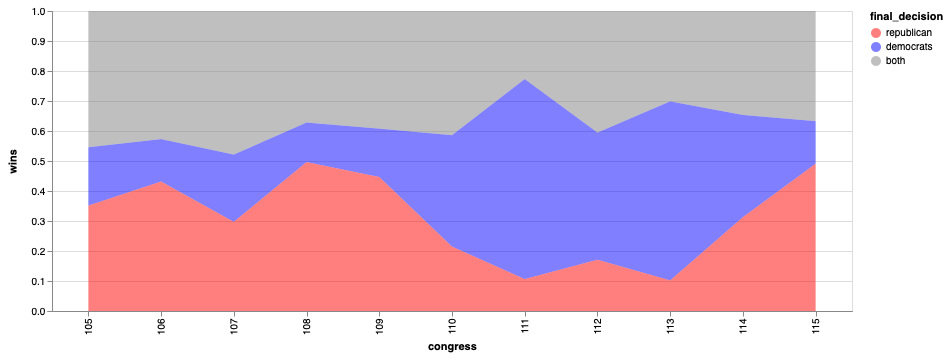

In [20]:
d = pd.DataFrame(all_laws.groupby(['congress', 'final_decision']).size()).reset_index().rename(columns={0: 'wins'})
counts = pd.DataFrame(all_laws.groupby(['congress']).size()).reset_index().rename(columns={0: 'total'})
d = d.merge(counts)
d['wins'] = d['wins'] / d['total']

alt.Chart(d, width=800, height=300).mark_area(opacity=0.5).encode(
    x="congress:O",
    y="wins:Q",
    color=alt.Color("final_decision:N", 
                    scale=alt.Scale(domain=['republican', 'democrats', 'both'], 
                              range=[pal['republican'], pal['democrats'], 'grey'])))

#### How stable is the "yes" over time

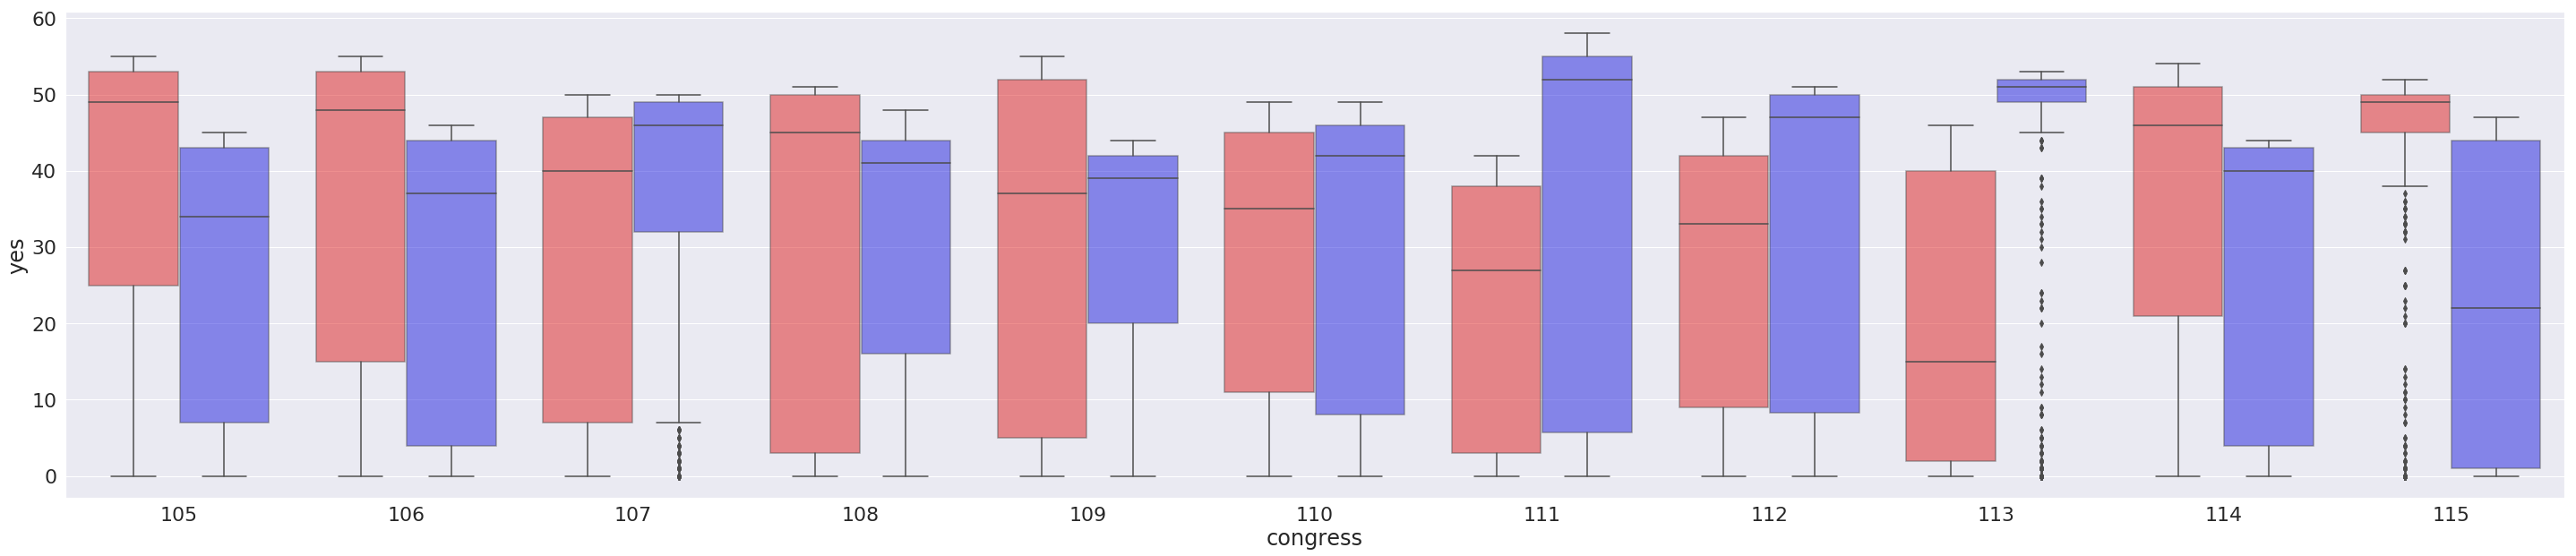

In [21]:
r = all_laws[['republican_yes', 'congress']].rename(columns={'republican_yes': 'yes'})
r['party'] = 'republican'
d = all_laws[['democrats_yes', 'congress']].rename(columns={'democrats_yes': 'yes'})
d['party'] = 'democrats'
d = pd.concat([r, d], axis=0)

plt.figure(figsize=(50, 10))
ax = sns.boxplot(x='congress', y='yes', hue='party', data=d, palette=pal, boxprops=dict(alpha=.5))
ax.legend_.remove()

### Intra Party

In [22]:
# 1 is perfect concordance, 0 is total discordance
def inside_concordance(yes, no):
    if yes == 0 or no == 0:
        return 1
    else:
        if yes > no:
            return yes / (yes + no)
        else:
            return no / (yes + no)

In [23]:
all_laws['republican_concordance'] = all_laws.apply(lambda x: inside_concordance(x['republican_yes'], x['republican_no']), axis=1)
all_laws['democrats_concordance'] = all_laws.apply(lambda x: inside_concordance(x['democrats_yes'], x['democrats_no']), axis=1)

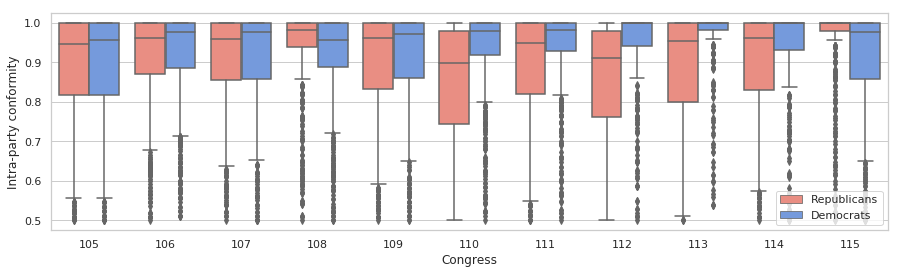

In [24]:
sns.set(style="whitegrid")

r = all_laws[['republican_concordance', 'congress']].rename(columns={'republican_concordance': 'concordance'})
r['party'] = 'republican'
d = all_laws[['democrats_concordance', 'congress']].rename(columns={'democrats_concordance': 'concordance'})
d['party'] = 'democrats'
d = pd.concat([r, d], axis=0)


plt.figure(figsize=(15, 4))
ax = sns.boxplot(x='congress', y='concordance', hue='party', data=d, palette=sns.color_palette(['salmon','cornflowerblue']))
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ['Republicans', 'Democrats'], loc = 'lower right')
plt.xlabel('Congress')
plt.ylabel('Intra-party conformity')
plt.savefig('figs/conform.pdf', bbox_inches='tight')